In [1]:
# This file is used for initial analysis of the ML techniques. It will not be used directly in the final application.

# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import yfinance as yf
import sklearn.metrics as metrics

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing stock data using yfinance

stockPrices = yf.download("C", start="2010-01-01")
stockPrices = stockPrices.dropna()
stockPrices = stockPrices.reset_index()
stockPrices = stockPrices.rename(columns={"Date": "date", "Open": "open", "High": "high", "Low": "low", "Close": "close", "Adj Close": "adjClose", "Volume": "volume"})

print(stockPrices.head())
 

[*********************100%%**********************]  1 of 1 completed

        date       open       high        low      close   adjClose    volume
0 2010-01-04  33.599998  34.099998  33.400002  34.000000  26.639053  40679350
1 2010-01-05  34.200001  35.500000  34.099998  35.299999  27.657598  66861710
2 2010-01-06  35.599998  36.799999  35.099998  36.400002  28.519461  67433890
3 2010-01-07  36.900002  37.000000  36.099998  36.500000  28.597801  67245190
4 2010-01-08  36.500000  36.700001  35.099998  35.900002  28.127699  62409770


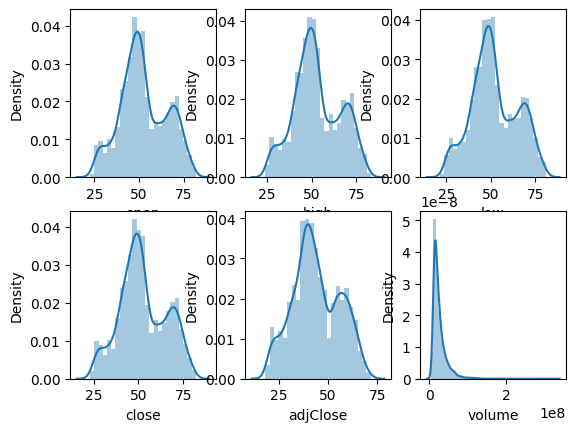

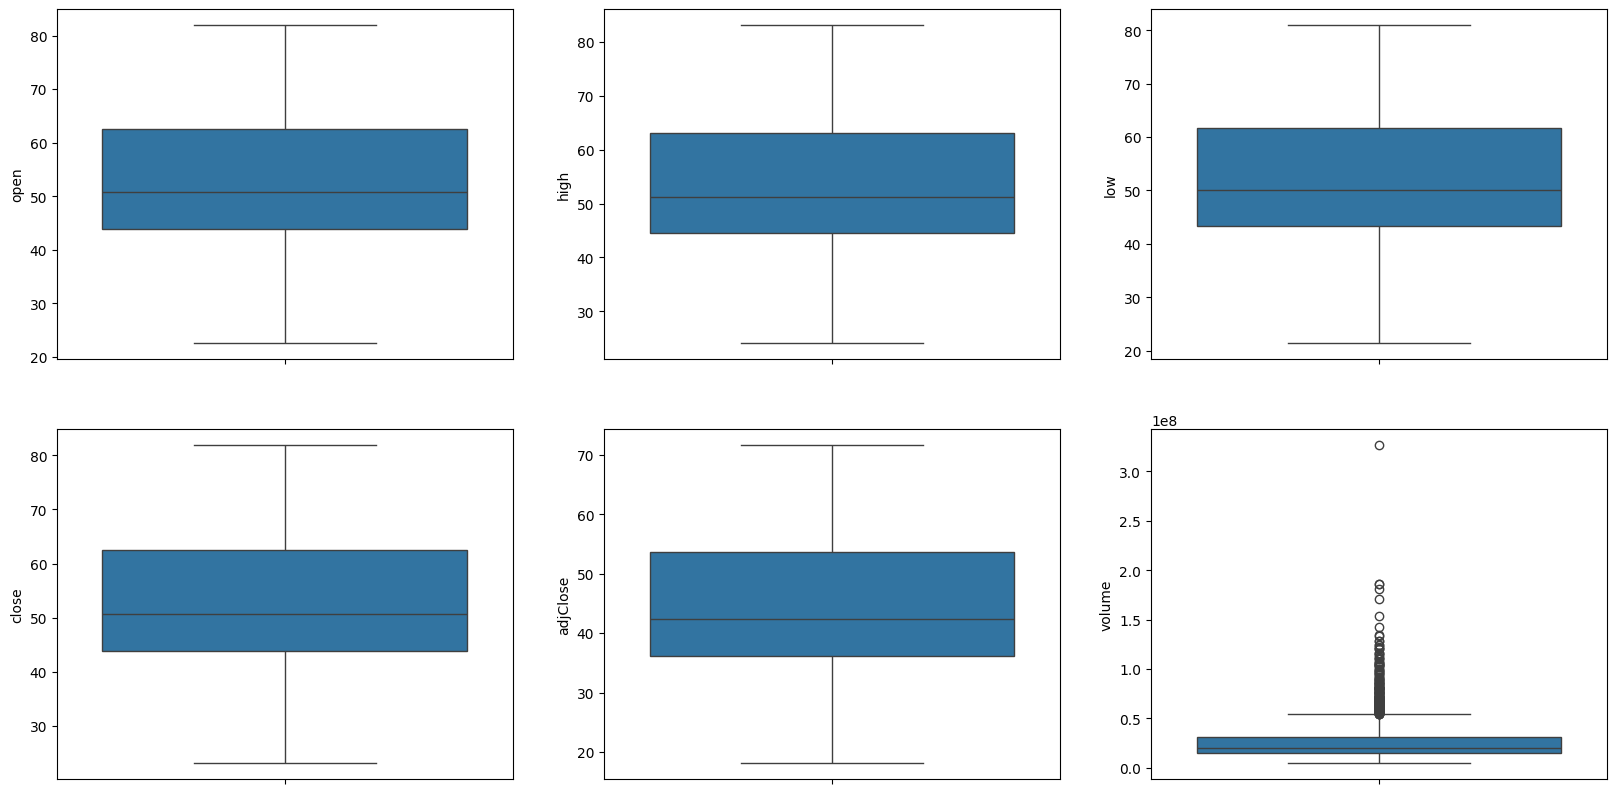

In [3]:
# Analyzing properties of data with distribution plots

features = ['open', 'high', 'low', 'close', 'adjClose', 'volume']

for i, col in enumerate(features):
    plt.subplot(2, 3, i+1)
    sb.distplot(stockPrices[col])
    
plt.show()

# Boxplots of data

plt.subplots(figsize=(20,10))
for i, col in enumerate(features):
  plt.subplot(2,3,i+1)
  sb.boxplot(stockPrices[col])
  
plt.show()

# Outliers appear to only exist in the volume boxplot


In [4]:
# Feature Engineering
# Deriving features from existing ones to try to improve the performance of the model

stockPrices['day'] = stockPrices['date'].dt.day
stockPrices['month'] = stockPrices['date'].dt.month
stockPrices['year'] = stockPrices['date'].dt.year
stockPrices = stockPrices.drop(columns=['date'])

# Adding a quarterly results variable (dummy variable) to capture the effects of results announcements

stockPrices['isQuarterEnd'] = np.where(stockPrices['month'] % 3 == 0, 1, 0)

print(stockPrices.head())

        open       high        low      close   adjClose    volume  day   
0  33.599998  34.099998  33.400002  34.000000  26.639053  40679350    4  \
1  34.200001  35.500000  34.099998  35.299999  27.657598  66861710    5   
2  35.599998  36.799999  35.099998  36.400002  28.519461  67433890    6   
3  36.900002  37.000000  36.099998  36.500000  28.597801  67245190    7   
4  36.500000  36.700001  35.099998  35.900002  28.127699  62409770    8   

   month  year  isQuarterEnd  
0      1  2010             0  
1      1  2010             0  
2      1  2010             0  
3      1  2010             0  
4      1  2010             0  


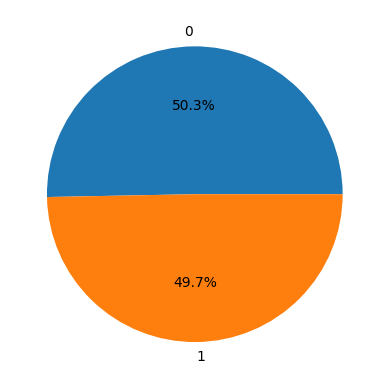

In [5]:
# Construct price change variables

stockPrices['dayChange'] = stockPrices['open'] - stockPrices['close']
stockPrices['dayRange'] = stockPrices['high'] - stockPrices['low']

# Checking if price in the day after is greater than the closing price in the day before
# Sets to 1 if true, 0 if false
stockPrices['target'] = np.where(stockPrices['close'].shift(-1) > stockPrices['close'], 1, 0)

# Checking to see if distribution of 'target' variable is balanced or not
plt.pie(stockPrices['target'].value_counts().values, labels=[0, 1], autopct='%1.1f%%')
plt.show()


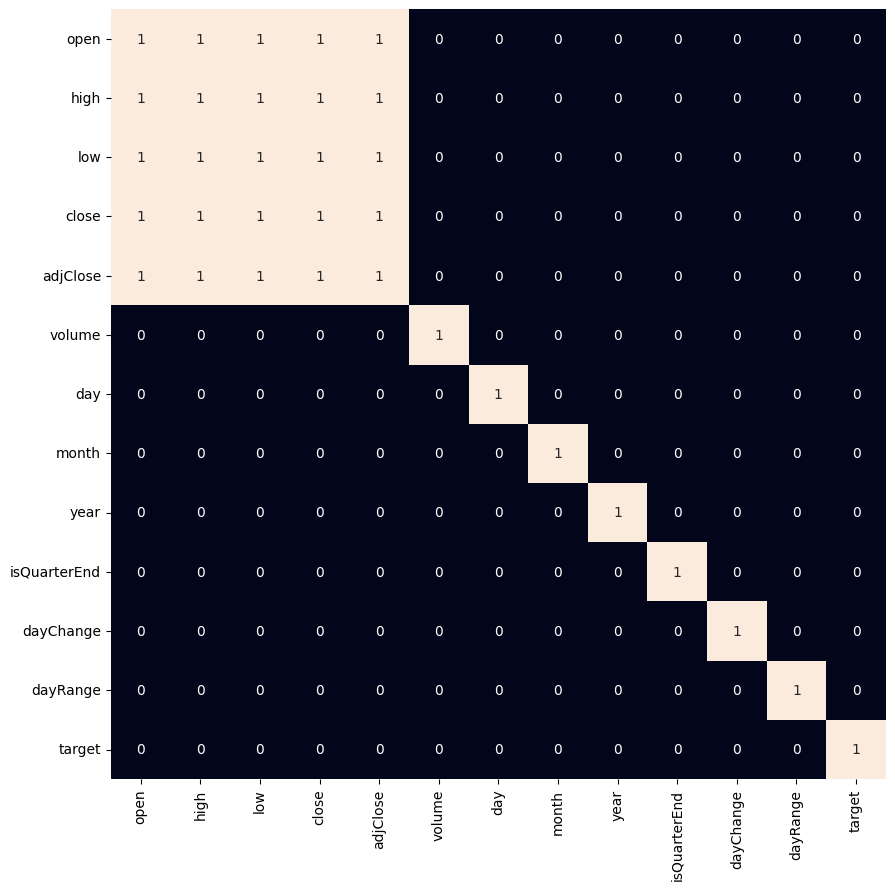

In [6]:
# Checking for correlation between added variables

plt.figure(figsize=(10, 10))
sb.heatmap(stockPrices.corr() > 0.9, annot=True, cbar=False)
plt.show()

# Verified that the added variables are not highly correlated with each other

In [7]:
# Normalizing and splitting data

features = stockPrices[['dayChange', 'dayRange', 'isQuarterEnd']]
target = stockPrices['target']
 
scaler = StandardScaler()
features = scaler.fit_transform(features)
 
X_train, X_valid, Y_train, Y_valid = train_test_split(
    features, target, test_size=0.1, random_state=2022)

In [16]:
# Constructing models and evaluating their accuracy based on the out-of-sample data

models = [LogisticRegression(), SVC(
kernel='poly', probability=True), XGBClassifier()]

for i in range(3):
    models[i].fit(X_train, Y_train)

    print(f'{models[i]} : ')
    print('Training Accuracy : ', metrics.roc_auc_score(Y_train, models[i].predict_proba(X_train)[:,1])) # Only choosing right column in the 2D matrix
    print('Validation Accuracy : ', metrics.roc_auc_score(Y_valid, models[i].predict_proba(X_valid)[:,1]))

LogisticRegression() : 
Training Accuracy :  0.5137759501604968
Validation Accuracy :  0.48913043478260876
SVC(kernel='poly', probability=True) : 
Training Accuracy :  0.48854907025774463
Validation Accuracy :  0.4949183247359371
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) : 
Training 